# Stat 444 Exam 1
### Miles Lucas

## Question 1

##### a.
A non-informative prior for a single-parameter ($\theta$) distribution is a way of saying "We don't really know much about this parameter or what to expect".  An easy example of what this looks like would be using a uniform distribution. With this, we say that all possible values are equally likely - that's about as non-informative as you can get!

##### b.
The marginal posterior distribution of a parameter $\theta_1$ is two parts: a marginal and a posterior distribution. In a Bayesian model, we update the parameters from their priors using data to create a posterior. The marginal posterior is just the distribution that describes one parameter (ie is integrated over every other parameter). 

##### c.
So I've already described what a posterior distribution is, so now I just have to describe a a quantile is. A quantile is a way of describing where a value is in a distribution. It, mathematically, resembles the total area of the curve below that value. The median is the 50th quantile (half below, half above). The 40th quantile, then, is the point where 40% of the distribution lies below that point.

##### d.
Rejection sampling theorem is a way of getting random samples given only a distribution of a parameter. This works by creating an envelope. Algorithmically, we take a uniform sample of the abscissa and then a uniform sample within the height of the envelope at that value. If this second sample is less than the distribution we want to sample from, then we accept that value. Otherwise we reject it. 

##### e.
If our data has a likelihood function, eg Normal, then we want to be able to describe what the likelihood function for the data is after updating the parameters using Bayes' method. This updated distribution is the posterior predictive. 

## Question 2

Let P(b) be the probability of the bill having value b and let P(d) be the probability of drawing a bill of value d. We want to know what is the probability of the last bill having value 20 given that we drew a bill of value 5 for my coffee. 

$$
P(b=20 | d=5) \propto P(d=5 | b=20)\cdot P(b=20)
$$

The probability of pulling a five dollar bill if the original bill was a 20 is 0.5. In comparison, the probability of drawing a 5 dollar dill given an original of 5 is 1.0. So, we have

$$
P(b=20 | d=5) \propto (0.5)(0.5) = 0.25
$$
$$
P(b=5 | d=5) \propto (1)(0.5) = 0.5
$$

Therefore the normalization constant is $0.25 + 0.5 = 0.75$ and the final probability looks like
$$
P(b=20 | d=5) = \frac{(0.5)(0.5)}{0.75} = 0.33
$$
$$
P(b=5 | d=5) = \frac{(1)(0.5)}{0.75} = 0.67
$$

So the probability that I have \$20 in my pocket is 1/3...realistically it's 0, though, because I just checked and there's no money.

## Question 3

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)

##### a.
Here I load the data, group the data by the origin (0 = import, 1 = domestic) and get the summary statistics for the alcohol content for each treatment

In [5]:
beers = pd.read_table('beer.txt', delimiter='\s+', names=['brand', 'price', 'calories', 'apv', 'type', 'origin'])
apv_groups = beers.groupby('origin')['apv']
apv_groups.describe()

,count,mean,std,min,25%,50%,75%,max
origin,,,,,,,,
0,15.0,4.133333,1.743833,0.0,4.2,4.9,5.000,5.6
1,54.0,4.500000,1.532786,0.0,4.5,4.9,5.275,6.0


C:\Users\miles\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


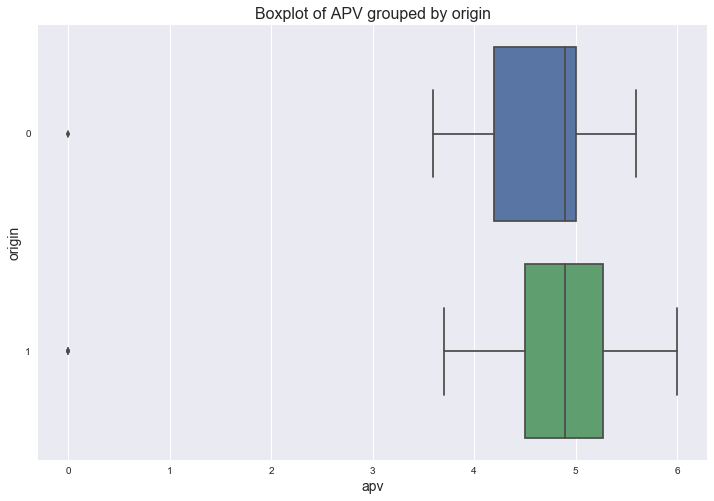

In [6]:
plt.title('Boxplot of APV grouped by origin')
sns.boxplot(x='apv', y='origin', data=beers, orient='h')

##### b. 
Given 
$$
p(\mu_i, \sigma_i^2)\propto \frac{1}{\sigma_i^2}
$$
I can say that $p(\mu_i)\propto 1$ and $p(\sigma_i^2) \propto 1/\sigma_i^2$
Therefore using Bayes' rule
$$
P(\mu_i, \sigma_i^2 | y) \propto P(y | \mu_i, \sigma_i^2) P(\mu_i, \sigma_i^2) = \sigma^{-2} N(y|\mu_i, \sigma_i^2)
$$
The marginal posterior for $\sigma_i^2$ ends up having an analytical solution
$$
P(\sigma_i^2 | y) \propto (\sigma_i^2)^{-(n+1)/2}\exp\left({- \frac{(n-1)s^2}{2\sigma_i^2}}\right)
$$

The posterior for $\mu$ looks like $\mu_i | \sigma_i^2, y \sim N(\bar{y}, \sigma_i^2/n)$. The marginal can be found, as well, with an analytical solution
$$
P(\mu_i | y) \propto \left[1 + \frac{n(\mu_i-\bar{y})^2}{(n-1)s^2} \right]^{-n/2}
$$

The joint posterior, then is
$$
P(\mu_i, \sigma_i^2 | y) = P(\mu_i | y)P(\sigma_i^2 | y) \propto (\sigma_i^2)^{-(n+1)/2}\exp\left({- \frac{(n-1)s^2}{2\sigma_i^2}}\right) \left[1 + \frac{n(\mu_i-\bar{y})^2}{(n-1)s^2} \right]^{-n/2}
$$

##### c.
For these calculations I treat all distributions as log distributions for computational efficiency

In [7]:
from emcee import EnsembleSampler

def log_sigma2_posterior(sigma2, y):
    n = len(y)
    s2 = np.var(y)
    if sigma2 < 0:
        return -np.inf  # log(0)
    else:
        return -(n + 1) / 2 * np.log(sigma2) - (n - 1) * s2 / (2 * sigma2)

def log_mu_posterior(mu, y):
    n = len(y)
    s2 = np.var(y)
    return -n/2 * np.log(1 + n * (mu - np.mean(y))**2 / ((n-1)*s2))

def log_joint_posterior(theta, y):
    mu, sigma2 = theta
    return log_sigma2_posterior(sigma2, y) + log_mu_posterior(mu, y)

ndim = 2
nwalkers = 50
nburn = 1000 # Number of steps that will be discarded from beginning
nsteps = 2000 # Number of samples is nsteps - nburn
starting_guesses = np.random.random((nwalkers,ndim))

sampler0 = EnsembleSampler(nwalkers, ndim, log_joint_posterior, args=[apv_groups.get_group(0).values])
sampler0.run_mcmc(starting_guesses, nsteps);
trace0 = sampler0.chain[:, nburn:, :].reshape(-1, ndim).T

sampler1 = EnsembleSampler(nwalkers, ndim, log_joint_posterior, args=[apv_groups.get_group(1).values])
sampler1.run_mcmc(starting_guesses, nsteps);
trace1 = sampler1.chain[:, nburn:, :].reshape(-1, ndim).T

Text(0.5,0.98,'Imported')

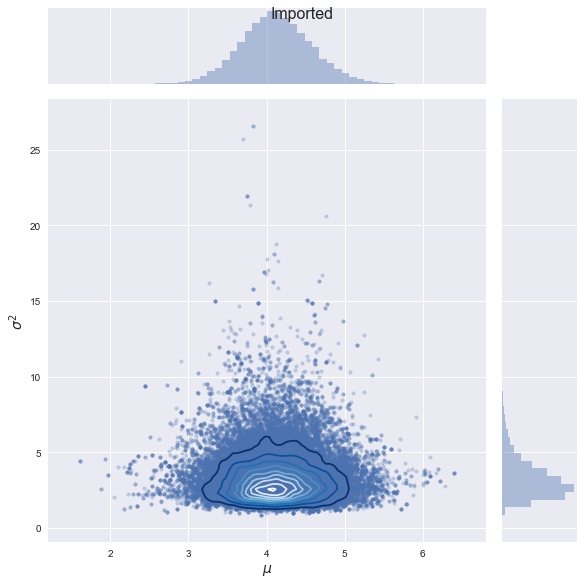

In [8]:
g = sns.JointGrid(x=trace0[0], y=trace0[1], size=8)
g.plot_joint(plt.scatter, marker='.', alpha=.3)
g.plot_joint(sns.kdeplot, cmap='Blues_r')
g.plot_marginals(sns.distplot, kde=False)
g.set_axis_labels(r'$\mu$', r'$\sigma^2$', fontsize=14);
plt.suptitle('Imported', fontsize=16)

Text(0.5,0.98,'Domestic')

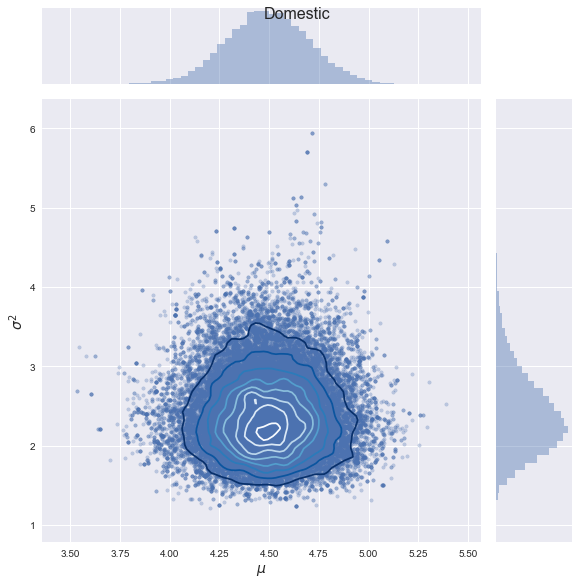

In [9]:
g = sns.JointGrid(x=trace1[0], y=trace1[1], size=8)
g.plot_joint(plt.scatter, marker='.', alpha=.3)
g.plot_joint(sns.kdeplot, cmap='Blues_r')
g.plot_marginals(sns.distplot, kde=False)
g.set_axis_labels(r'$\mu$', r'$\sigma^2$', fontsize=14);
plt.suptitle('Domestic', fontsize=16)

##### d.

Note there are 50 walkers, not 1. Visualization worked better with all the same color

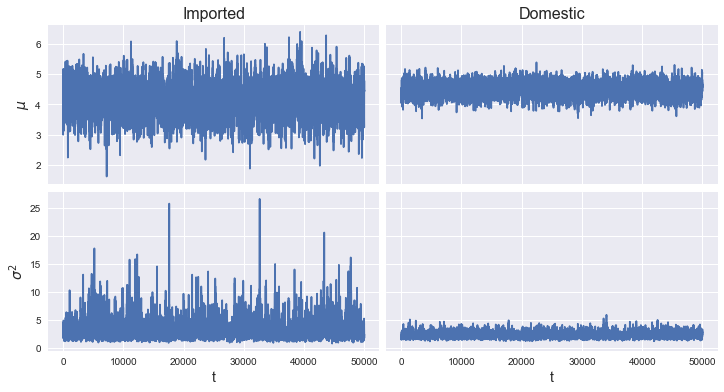

In [10]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12,6))
axes[0][0].plot(trace0[0])
axes[0][1].plot(trace1[0])
axes[1][0].plot(trace0[1])
axes[1][1].plot(trace1[1])

[ax.set_xlabel('t') for ax in axes[1]]
axes[0][0].set_ylabel(r'$\mu$')
axes[1][0].set_ylabel(r'$\sigma^2$')

axes[0][0].set_title('Imported')
axes[0][1].set_title('Domestic')

plt.subplots_adjust(wspace=0.02, hspace=0.05)

C:\Users\miles\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


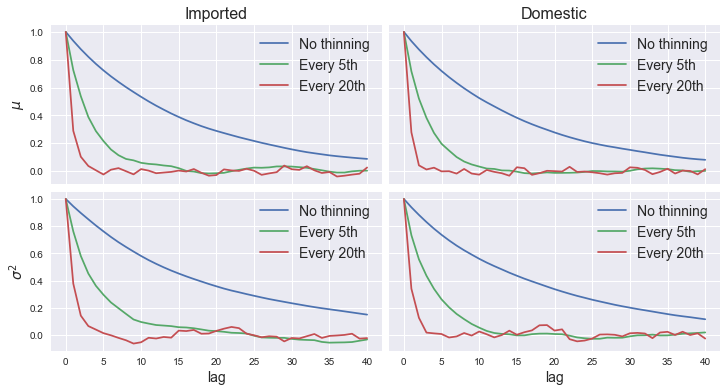

In [11]:
from statsmodels.tsa.stattools import acf
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12,6))

thins = [1, 5, 20]
for thinning in thins:
    axes[0][0].plot(acf(trace0[0, ::thinning]))
    axes[0][1].plot(acf(trace1[0, ::thinning]))
    axes[1][0].plot(acf(trace0[1, ::thinning]))
    axes[1][1].plot(acf(trace1[1, ::thinning]))

labels = ['No thinning', f'Every {thins[1]}th', f'Every {thins[2]}th']
[[a.legend(labels) for a in ax] for ax in axes]
[ax.set_xlabel('lag') for ax in axes[1]]
axes[0][0].set_ylabel(r'$\mu$')
axes[1][0].set_ylabel(r'$\sigma^2$')

axes[0][0].set_title('Imported')
axes[0][1].set_title('Domestic')

plt.subplots_adjust(wspace=0.02, hspace=0.05)

Given these autocorrelations, I might want to thin by picking every 10th or 20th value so I can reduce overall correlation in my walkers. 

e.

Because $\mu \sim N$ the difference should have a normal shape. Therefore I will create a simple credible set for the difference of the alcohol content and report whether 0 lies within that set. If not, the beers are different enough!

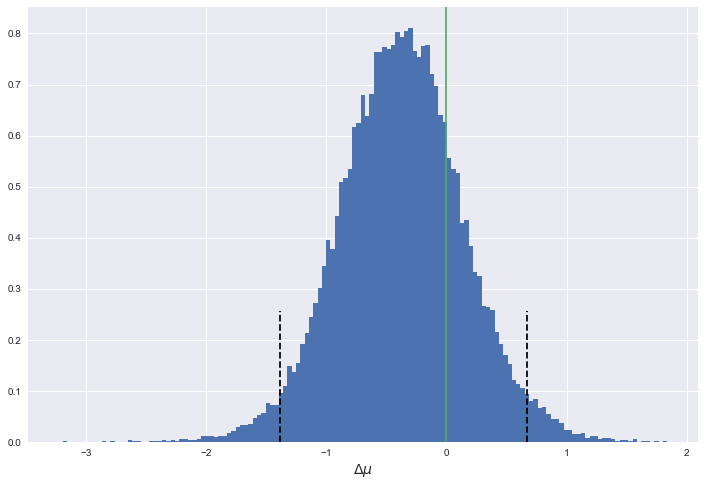

In [12]:
diff = trace0[0] - trace1[0]
plt.hist(diff, bins='auto', density=True);
p1,p2 = np.percentile(diff, [2.5, 97.5])
plt.axvline(p1, ymax=.3, color='k', ls='--')
plt.axvline(p2, ymax=.3, color='k', ls='--')
plt.axvline(0, ymax=1, color='C1', ls='-')
plt.xlabel(r'$\Delta\mu$');

The 95% credible set includes 0, so I conclude that there is no difference in alcohol content between domestic and imported beers within 95% margins

##### f.

For this I will create a 95% credible set about the difference of the two $\sigma^2$ traces to see if it includes 0

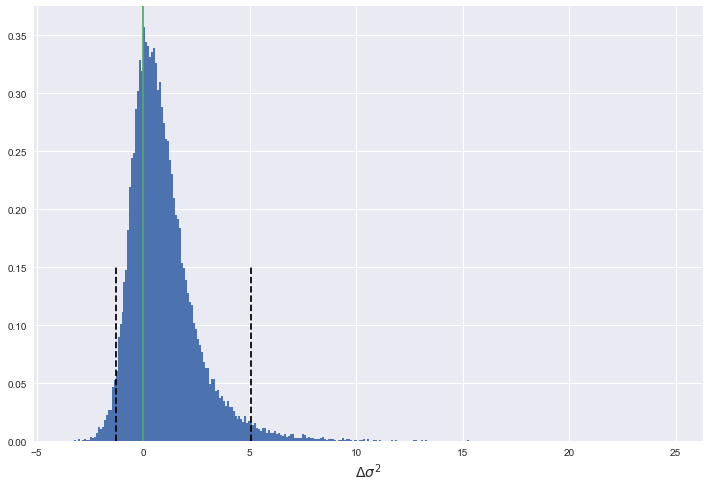

In [13]:
diffs2 = trace0[1] - trace1[1]
plt.hist(diffs2, bins='auto', density=True)
p1,p2 = np.percentile(diffs2, [2.5, 97.5])
plt.axvline(p1, ymax=.4, color='k', ls='--')
plt.axvline(p2, ymax=.4, color='k', ls='--')
plt.axvline(0, ymax=1, color='C1', ls='-')
plt.xlabel(r'$\Delta\sigma^2$');

0 is in the credible set, so the two sets are likely homogenous

## Question 4

The prior given has equal likelihood of the car being behind any door
$$
P(c=A)=P(c=B)=P(c=C)=1/3
$$

Given that I select door A and Monty opens door B, there are three scenarios to consider
$$
P(m=B | c=A) = 1/2
$$
Monty can pick either door B or C without consequence
$$
P(m=B | c=B) = 0
$$
Monty will never reveal the car
$$
P(m=B | c=C) = 1
$$
Monty will never reveal the car and cannot reveal the same door I picked, so he HAS TO open door B

Now I can consider the probability of the car being behind each door given what Monty has picked
$$
P(c=A | m=B) \propto P(m=B | c=A)\cdot P(c=A) = \frac{1}{2}\cdot \frac{1}{3} = \frac{1}{6}
$$
$$
P(c=B | m=B) \propto P(m=B | c=B)\cdot P(c=B) = 0\cdot \frac{1}{3} = 0
$$
$$
P(c=C | m=B) \propto P(m=B | c=C)\cdot P(c=C) = 1\cdot \frac{1}{3} = \frac{1}{3}
$$

The marginal likelihood $P(m=B) = 1/6 + 1/3 = 1/2$ so our final probabilities are
$$
P(c=A | m=B) = \frac{1}{3}
$$
$$
P(c=B | m=B) = 0
$$
$$
P(c=C | m=B) = \frac{2}{3}
$$

Remember in this setup that I choose door A, so I need to decide whether to switch or not dependent on Monty showing the goat behind door B. In this case, it is clear to see that there is a higher likelihood of getting the car behind door C so I should switch!

## Question 5

In [14]:
sales = pd.read_csv('Sales.csv', index_col=0)

##### a.

To get the average monthly change in sales, I will create a new series by taking N[1:] - N[:-1]

In [15]:
import pymc3 as pm

with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ t', sales)
    # Inferences
    trace = pm.sample(1000, cores=4)


You can find the C code in this temporary file: C:\Users\miles\AppData\Local\Temp\theano_compilation_error_c3lyz220


AttributeError: module 'theano' has no attribute 'gof'

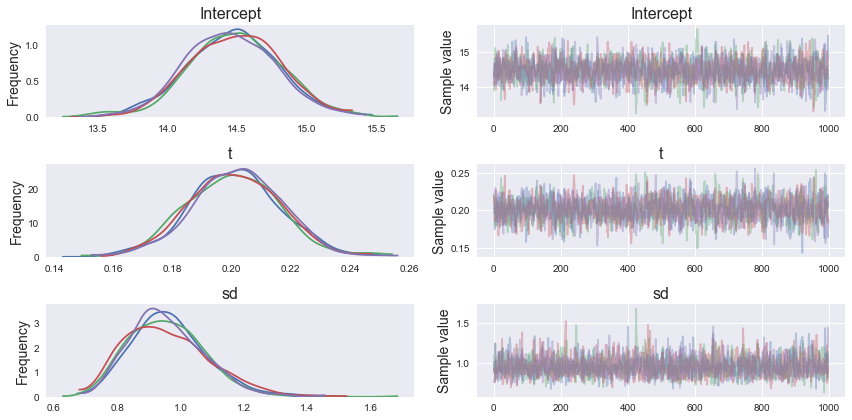

In [13]:
pm.traceplot(trace);

##### a. 
Here we can see the summary stats for the slope variable. This shows that the average change from month to month is \$201,000 and gives a 95% HPD (Should be very similar to credible set). What these values are saying is that a good show of how the change in sales varies and in any given month could be from \$171,000 to \$231,000


In [14]:
pm.stats.summary(trace, ['t',])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t,0.201117,0.015494,0.000347,0.169632,0.230047,1607.0,1.00036


##### b.
Here I show the $R^2$ value (using means), the mean line of fit, and two standard deviations from that line. 

Text(0,0.5,'Sales (millions of USD)')

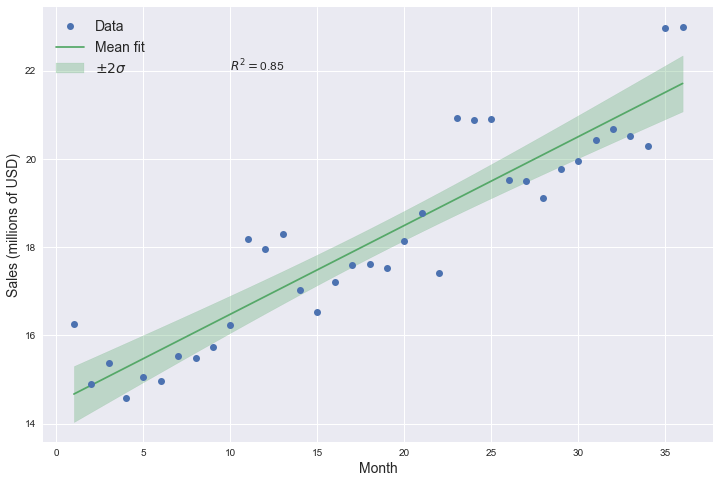

In [15]:
plt.plot(sales['t'], sales['y'], 'o', label='Data', zorder=3)
yfit = [sales['t'] * t + i  for t, i in zip(trace['t'], trace['Intercept'])]
r2 = pm.r2_score(sales['y'], np.mean(yfit, 0))
plt.annotate(rf'$R^2=${r2.r2_mean}', (10, 22))
plt.fill_between(sales['t'], np.mean(yfit, 0)-2*np.std(yfit, 0), np.mean(yfit, 0) + 2*np.std(yfit, 0), color='C1', alpha=.3, label=r'$\pm2\sigma$')
plt.plot(sales['t'], np.mean(yfit, 0), label='Mean fit')
plt.legend(fontsize=14)
plt.xlabel('Month')
plt.ylabel('Sales (millions of USD)')

##### c.
In these residuals I wouldn't quite say there is homscedastic error around 0, or any other central value.

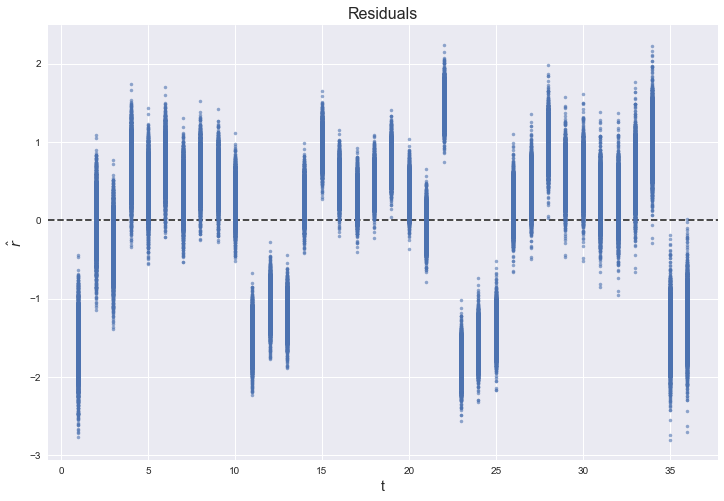

In [16]:
[plt.plot(y - sales['y'], '.C0', alpha=.6) for y in yfit]
plt.axhline(0, ls='--', color='.2', zorder=1)
plt.title('Residuals')
plt.ylabel(r'$\hat{r}$')
plt.xlabel('t');

In [17]:
in_season_t = sales.loc[sales['season']==1, 't']
in_season_y = sales.loc[sales['season']==1, 'y']
out_season_t = sales.loc[sales['season']==0, 't']
out_season_y = sales.loc[sales['season']==0, 'y']

with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ t', sales[sales['season']==1])
    trace_in = pm.sample(1000, cores=4)
    
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ t', sales[sales['season']==0])
    trace_out = pm.sample(1000, cores=4)
    
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, t, Intercept]
The acceptance probability does not match the target. It is 0.882396944761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.652162912308, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885331408909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.919711714606, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 c

Text(0.5,0.98,'Out of season')

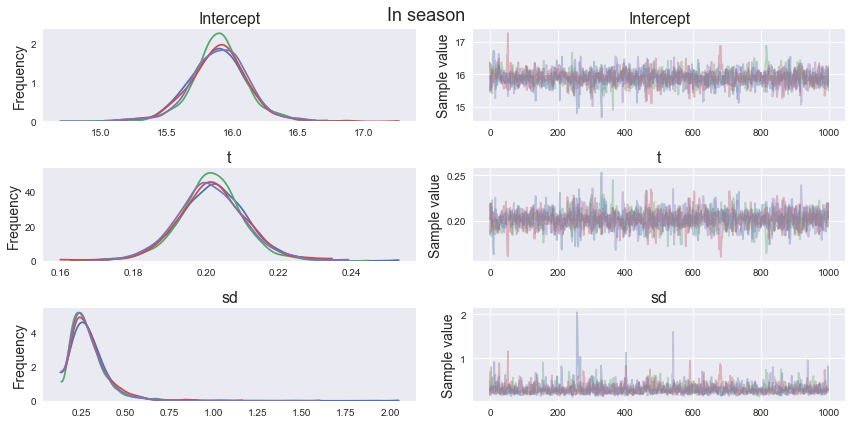

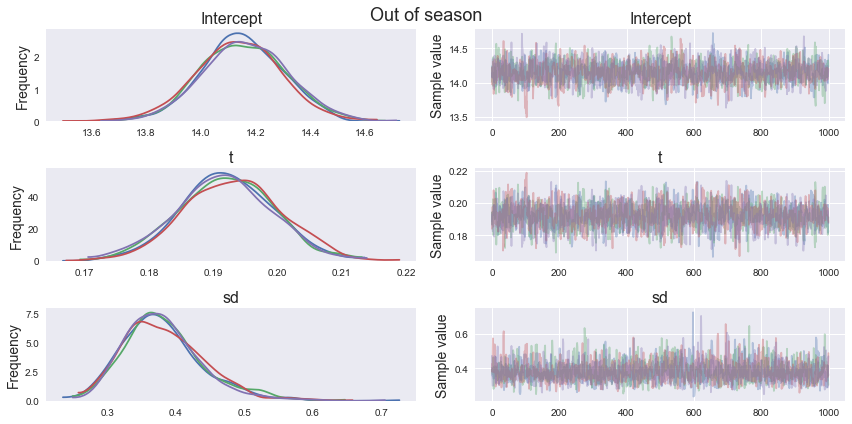

In [18]:
pm.traceplot(trace_in)
plt.suptitle('In season', fontsize=18)
pm.traceplot(trace_out)
plt.suptitle('Out of season', fontsize=18)

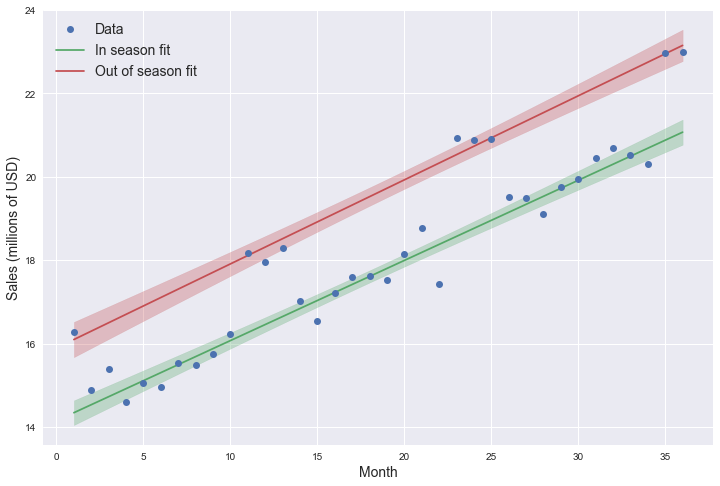

In [19]:
plt.plot(sales['t'], sales['y'], 'o', label='Data', zorder=3)
yfit0 = [sales['t'] * t + i  for t, i in zip(trace_out['t'], trace_out['Intercept'])]
yfit1 = [sales['t'] * t + i  for t, i in zip(trace_in['t'], trace_in['Intercept'])]

plt.fill_between(sales['t'], np.mean(yfit0, 0)-2*np.std(yfit0, 0), np.mean(yfit0, 0) + 2*np.std(yfit0, 0), color='C1', alpha=.3)
plt.plot(sales['t'], np.mean(yfit0, 0), label='In season fit')
plt.fill_between(sales['t'], np.mean(yfit1, 0)-2*np.std(yfit1, 0), np.mean(yfit1, 0) + 2*np.std(yfit1, 0), color='C2', alpha=.3)
plt.plot(sales['t'], np.mean(yfit1, 0), label='Out of season fit')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sales (millions of USD)');

So clearly there are *more* sales during the holiday months, but at first glance it doesn't look like there is a difference in the slope. 

Let's look at the difference in the means:

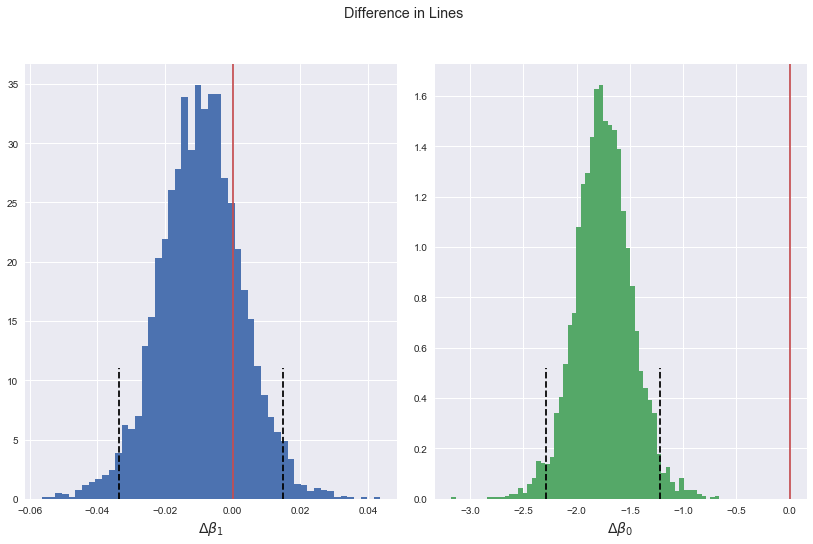

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
plt.suptitle('Difference in Lines')
diff_t = trace_out['t'] - trace_in['t']
axes[0].hist(diff_t, density=True, bins='auto')
p1,p2 = np.percentile(diff_t, [2.5, 97.5])
axes[0].axvline(p1, ymax=.3, color='k', ls='--')
axes[0].axvline(p2, ymax=.3, color='k', ls='--')
axes[0].axvline(0, ymax=1, color='C2', ls='-')
axes[0].set_xlabel(r'$\Delta\beta_1$')

diff_i = trace_out['Intercept'] - trace_in['Intercept']
axes[1].hist(diff_i, density=True, bins='auto', color='C1')
p1,p2 = np.percentile(diff_i, [2.5, 97.5])
axes[1].axvline(p1, ymax=.3, color='k', ls='--')
axes[1].axvline(p2, ymax=.3, color='k', ls='--')
axes[1].axvline(0, ymax=1, color='C2', ls='-')
axes[1].set_xlabel(r'$\Delta\beta_0$')
plt.subplots_adjust(wspace=.1)

In [21]:
np.mean(diff_i)

-1.7447496198612829

So, it looks like the slopes are not really credibly different but that, on average, seasonal months sell $1.75 million more.

##### d. Residuals

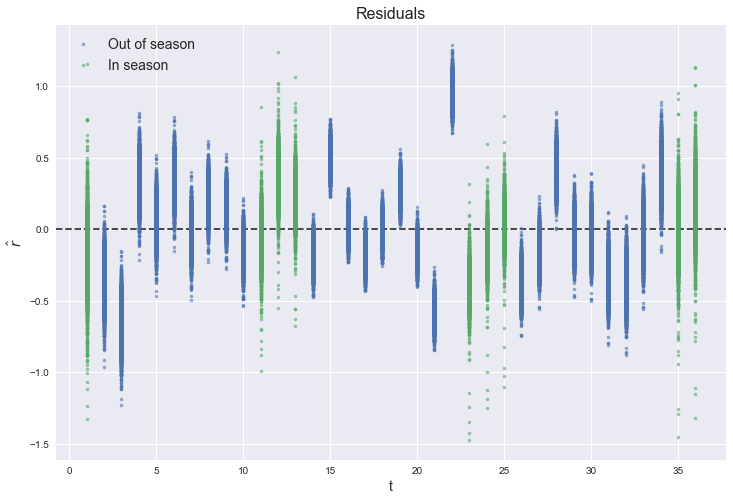

In [22]:
plt.title('Residuals')
plt.ylabel(r'$\hat{r}$')
plt.xlabel('t')

mask = sales['season']==0
index = sales[mask].index
dots = [plt.plot(y[index] - sales['y'][mask], '.C0', alpha=.6) for y in yfit0]
dots[0][0].set_label('Out of season')
plt.axhline(0, ls='--', color='.2', zorder=1)

mask = sales['season']==1
index = sales[mask].index
dots = [plt.plot(y[index] - sales['y'][mask], '.C1', alpha=.6) for y in yfit1]
dots[0][0].set_label('In season')

plt.legend();

I would say I am comfortable with this solution. The only outliers are months directly surrounding the change in seasons, which could be a detriment of the definition of seasonal months.

## Bonus Question

##### a. Likelihood Function
It is split up into $y$s before $k$ and after $k$
$$
P(y | \lambda, \phi, k) = \prod_{i=1}^k {\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}} \prod_{i=k+1}^n {\frac{e^{-\phi}\phi^{y_i}}{y_i!}}
$$

##### b. Priors

$$
P(\lambda, \phi, k | y) \propto P(y|\lambda, \phi, k) P(\lambda, phi, k)
$$

$$
P(y | \lambda, \phi, k) \propto \prod_{i=1}^k {e^{-\lambda}\lambda^{y_i}} \prod_{i=k+1}^n {e^{-\phi}\phi^{y_i}}
$$

$$
P(\lambda, \phi, k) \propto \lambda^{\alpha-1} e^{-\lambda \beta} \phi^{\gamma - 1} e^{-\phi \delta} k^{-1}
$$

$$
P(\lambda, \phi, k | y) \propto \prod_{i=1}^k {e^{-\lambda}\lambda^{y_i}} \prod_{i=k+1}^n {e^{-\phi}\phi^{y_i}} \times \lambda^{\alpha-1} e^{-\lambda \beta} \phi^{\gamma - 1} e^{-\phi \delta} k^{-1}
$$

$$
P(k | y, \lambda, \phi) \propto P(y, \lambda, \phi | k) P(k) = \prod_{i=1}^k {e^{-\lambda}\lambda^{y_i}} \prod_{i=k+1}^n {e^{-\phi}\phi^{y_i}} \times k^{-1}
$$

##### c. Results

To summarize my results, near the 42nd month the fatalities per month raised from ~4.7 to ~9.04. Before the 42nd month, fatalities per month ranged from 4.1 to 5.3 and after they ranged from 7.4 to 10.8, so there is a larger spread, too. The switch may have not occurred in the 42nd month, it could range from 31 to 43, but it is much closer to the upper part of the range. 